In [1]:
%pip install h5py numpy matplotlib pandas

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

plt.style.use('default')   

Note: you may need to restart the kernel to use updated packages.


In [ ]:
BASE_DIR = '../data_set/'

dataset_files = [
    #"N-CMAPSS_DS01-005.h5",
    "N-CMAPSS_DS02-006.h5",
    #"N-CMAPSS_DS03-012.h5",
]

def decode(byte_array):
    return [x.decode('utf-8') for x in byte_array]

def load_df(h5path, tag = None):
    hdf = h5py.File(h5path, 'r')
    
    A_var = decode(hdf["A_var"])
    T_var = decode(hdf["T_var"])
    W_var = decode(hdf["W_var"])
    Xs_var = decode(hdf["X_s_var"]) 

    A_dev = hdf["A_dev"][:]
    T_dev = hdf["T_dev"][:]
    W_dev = hdf["W_dev"][:]
    Xs_dev = hdf["X_s_dev"][:]
    Y_dev = hdf["Y_dev"][:]

    df = pd.concat([
        pd.DataFrame(A_dev, columns=A_var),
        pd.DataFrame(W_dev, columns=W_var),
        pd.DataFrame(Xs_dev, columns=Xs_var),
        pd.DataFrame(T_dev, columns=T_var)
    ], axis=1)

    df["RUL"] = Y_dev[:, 0]
    df["unit"] = df["unit"].astype('int')
    if tag is None:
        tag = os.path.basename(h5path).replace('.h5', '')

    df["dataset"] = tag
    df["engine_id"] = df["dataset"] + "_u" + df["unit"].astype(str)
    hdf.close()
    return df

dev_list = []
for file in dataset_files:
    h5path = os.path.join(BASE_DIR, file)
    tag = file.split(".h5")[0]
    df_i = load_df(h5path, tag=file.replace('.h5',''))

    engines = sorted(df_i["engine_id"].unique())
    print(f"Dataset: {tag}")
    print("Number of rows: ", len(df_i))
    print("Number of engines: ", len(engines))
    
    cyclestats = df_i.groupby("engine_id")["cycle"].agg(['min', 'max'])
    print("Cycles per engine (min/max):")
    print(cyclestats.describe())
    print("\n")
    dev_list.append(df_i)
    
df_dev = pd.concat(dev_list, ignore_index=True)
print("\ndf_Dev shape:", df_dev.shape)
print("Total unique engines: ", df_dev["engine_id"].nunique())
print("Units: ", sorted(df_dev["unit"].unique()))

print("\nCycles per unit (min/max):")
cyclestats = df_dev.groupby("unit")["cycle"].agg(['min', 'max'])

df_dev.describe().T.head(15)
df_dev 



Dataset: N-CMAPSS_DS02-006
Number of rows:  5263447
Number of engines:  6
Cycles per engine (min/max):
       min        max
count  6.0   6.000000
mean   1.0  74.333333
std    0.0   9.831921
min    1.0  63.000000
25%    1.0  67.250000
50%    1.0  73.000000
75%    1.0  80.250000
max    1.0  89.000000



df_Dev shape: (5263447, 35)
Total unique engines:  6
Units:  [np.int64(2), np.int64(5), np.int64(10), np.int64(16), np.int64(18), np.int64(20)]

Cycles per unit (min/max):


,unit,cycle,Fc,hs,alt,Mach,TRA,T2,T24,T30,...,LPC_flow_mod,HPC_eff_mod,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod,RUL,dataset,engine_id
0,2,1.0,3.0,1.0,10005.0,0.448497,76.903748,502.420918,600.148034,1438.498187,...,0.0,0.0,0.0,-0.000638,0.0,0.000000,0.000000,74,N-CMAPSS_DS02-006,N-CMAPSS_DS02-006_u2
1,2,1.0,3.0,1.0,10013.0,0.447741,76.903748,502.326114,600.055894,1438.350208,...,0.0,0.0,0.0,-0.000638,0.0,0.000000,0.000000,74,N-CMAPSS_DS02-006,N-CMAPSS_DS02-006_u2
2,2,1.0,3.0,1.0,10017.0,0.448938,77.079529,502.416067,600.210756,1439.109101,...,0.0,0.0,0.0,-0.000638,0.0,0.000000,0.000000,74,N-CMAPSS_DS02-006,N-CMAPSS_DS02-006_u2
3,2,1.0,3.0,1.0,10024.0,0.449883,77.079529,502.469893,600.369717,1439.240230,...,0.0,0.0,0.0,-0.000638,0.0,0.000000,0.000000,74,N-CMAPSS_DS02-006,N-CMAPSS_DS02-006_u2
4,2,1.0,3.0,1.0,10031.0,0.449379,77.079529,502.401271,600.298227,1439.064004,...,0.0,0.0,0.0,-0.000638,0.0,0.000000,0.000000,74,N-CMAPSS_DS02-006,N-CMAPSS_DS02-006_u2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5263442,20,66.0,3.0,0.0,10036.0,0.502866,38.407928,507.301734,567.846845,1286.087972,...,0.0,0.0,0.0,-0.007693,0.0,-0.023184,-0.006428,0,N-CMAPSS_DS02-006,N-CMAPSS_DS02-006_u20
5263443,20,66.0,3.0,0.0,10026.0,0.502551,38.583710,507.308340,567.942650,1287.089618,...,0.0,0.0,0.0,-0.007693,0.0,-0.023184,-0.006428,0,N-CMAPSS_DS02-006,N-CMAPSS_DS02-006_u20
5263444,20,66.0,3.0,0.0,10020.0,0.502866,38.847378,507.361541,568.241901,1288.541567,...,0.0,0.0,0.0,-0.007693,0.0,-0.023184,-0.006428,0,N-CMAPSS_DS02-006,N-CMAPSS_DS02-006_u20
5263445,20,66.0,3.0,0.0,10012.0,0.502740,38.935268,507.380028,568.462600,1288.872381,...,0.0,0.0,0.0,-0.007693,0.0,-0.023184,-0.006428,0,N-CMAPSS_DS02-006,N-CMAPSS_DS02-006_u20


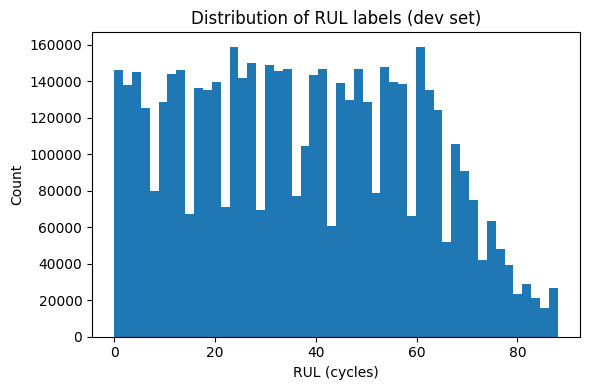

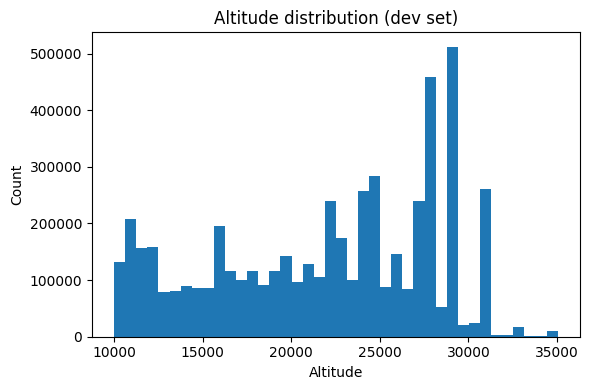

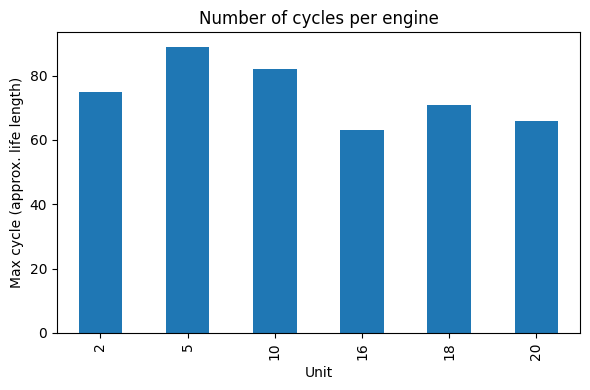

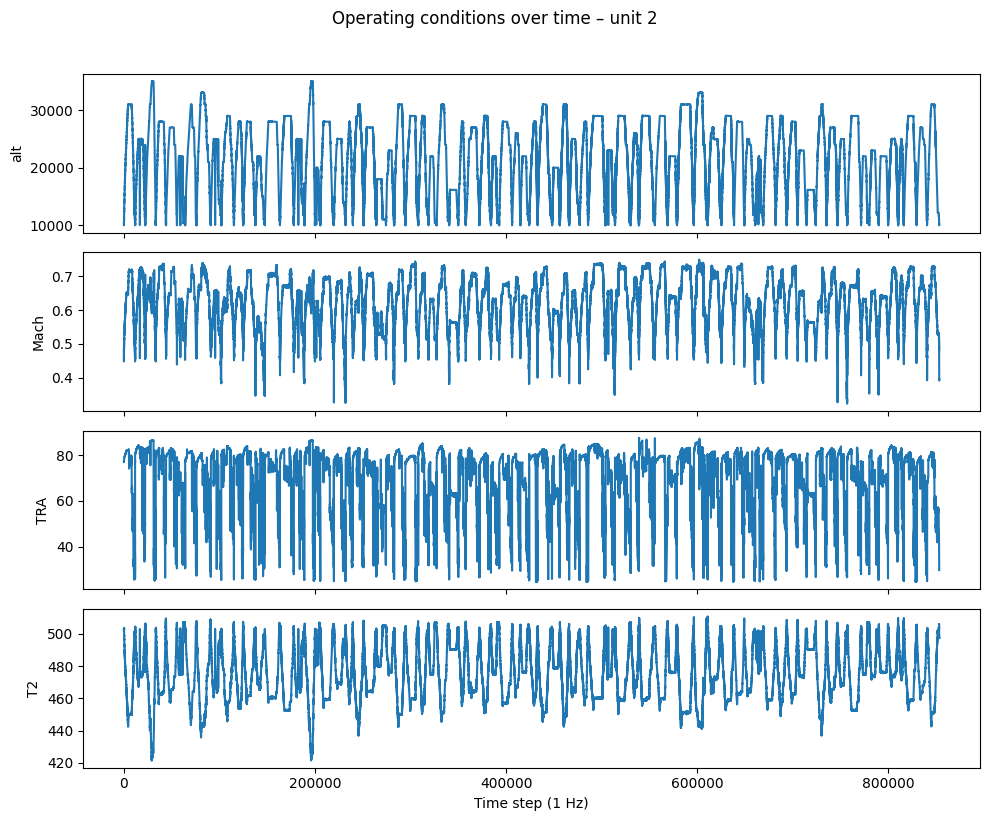

C:\Users\vaibh\AppData\Local\Temp\ipykernel_44672\1003333361.py:71: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\vaibh\miniconda3\envs\cs178\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


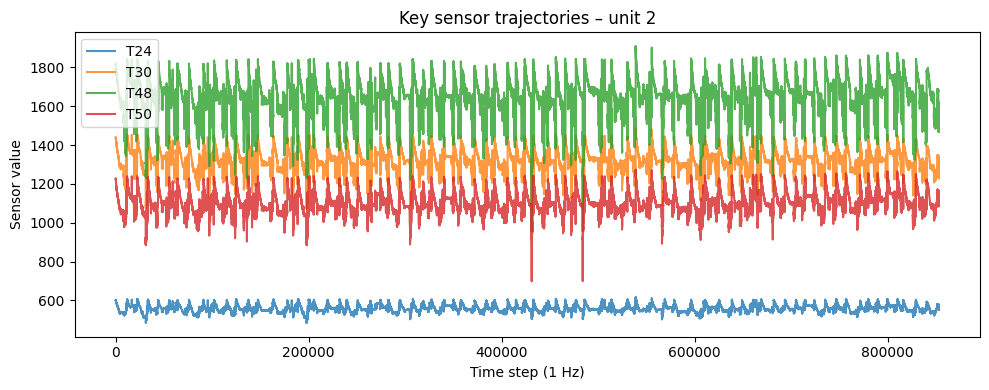

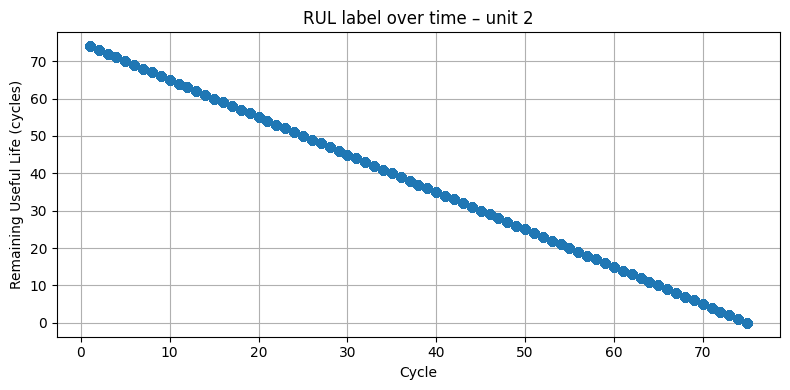

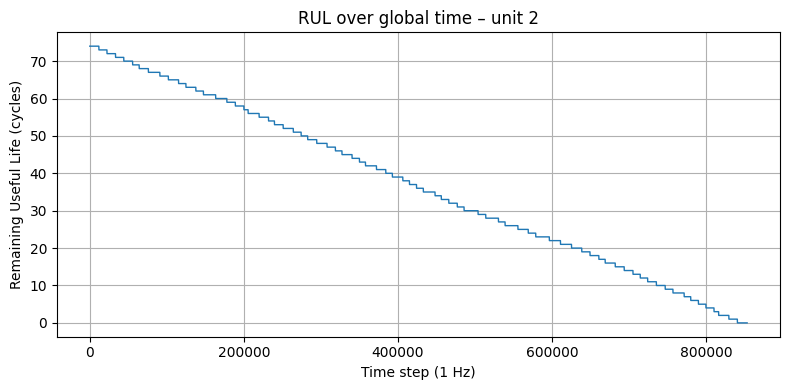

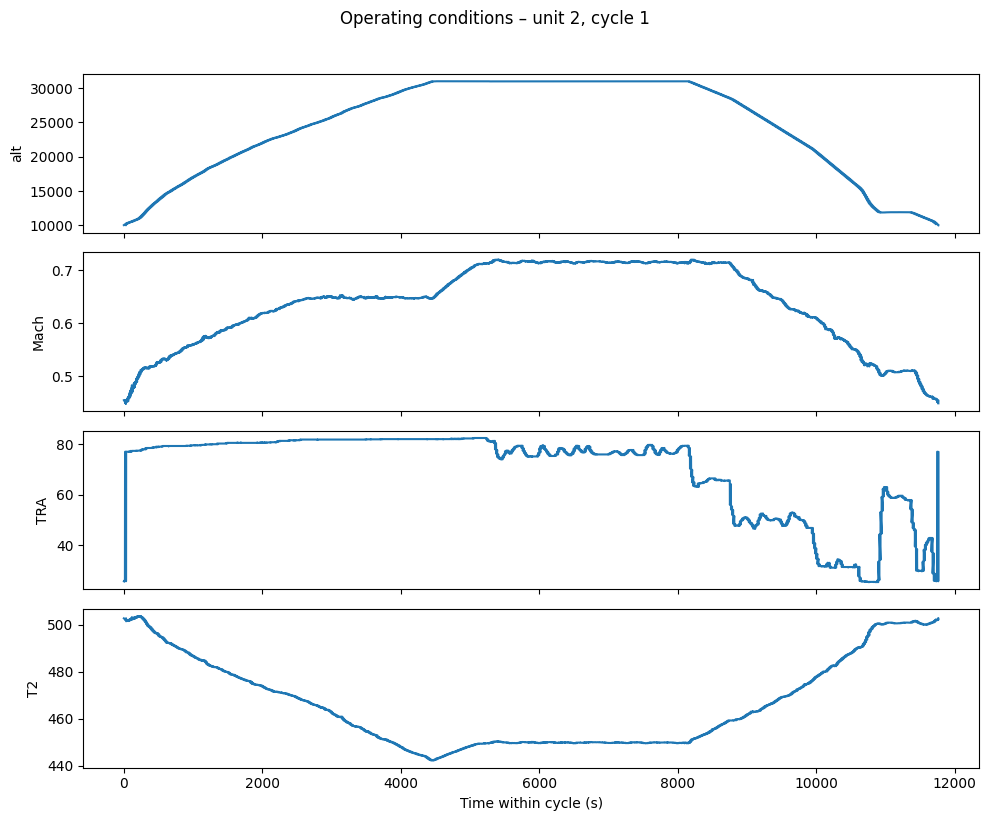

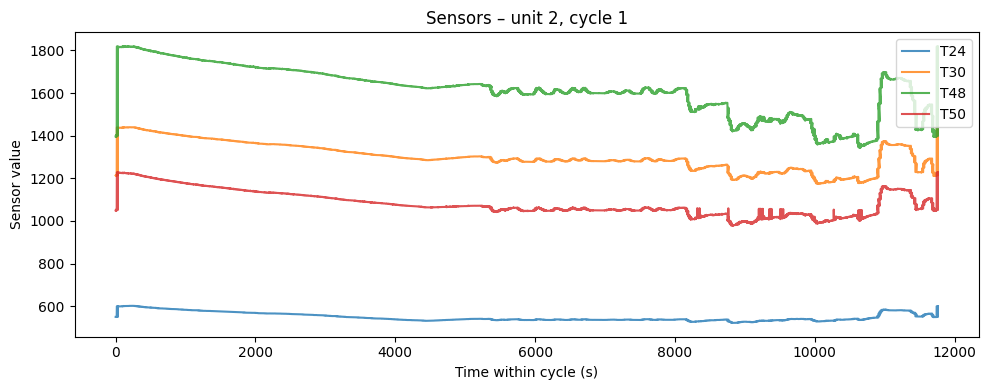

'\n\nimport matplotlib.gridspec as gridspec\nimport seaborn as sns\nimport matplotlib\n\n\nwith h5py.File(os.path.join(BASE_DIR, "N-CMAPSS_DS02-006.h5"), "r") as hdf:\n    A_dev  = hdf["A_dev"][:]\n    W_dev  = hdf["W_dev"][:]\n    A_test = hdf["A_test"][:]\n    W_test = hdf["W_test"][:]\n\n    A_var  = decode(hdf["A_var"])\n    W_var  = decode(hdf["W_var"])\n\nA = np.concatenate([A_dev, A_test], axis=0)\nW = np.concatenate([W_dev, W_test], axis=0)\n\ndf_A = pd.DataFrame(A, columns=A_var)\ndf_W = pd.DataFrame(W, columns=W_var)\ndf_W["unit"] = df_A["unit"].values\n\nunits   = sorted(df_A["unit"].unique())\nleg     = [f"Unit {int(u)}" for u in units]\nvariables = ["alt", "Mach", "TRA", "T2"]\nlabels    = ["Altitude [ft]", "Mach Number [-]",\n             "Throttle Resolver Angle [%]",\n             "Temperature at fan inlet [°R]"]\n\ndef plot_kde(leg, variables, labels, size, units, df_W, df_A, labelsize=17, name=None):\n    """\n    """\n    plt.clf()\n       \n    input_dim = len(varia

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

unit_id  = 2   # engine to visualize
cycle_id = 1   # one flight from that engine


sensor_cols = ["T24", "T30", "T48", "T50"]  
op_cols     = ["alt", "Mach", "TRA", "T2"]


df_unit = df_dev[df_dev["unit"] == unit_id].copy().sort_values(["cycle"])
df_unit["time_idx"] = np.arange(len(df_unit))

df_uc = df_dev[(df_dev["unit"] == unit_id) & (df_dev["cycle"] == cycle_id)].copy()
df_uc = df_uc.sort_values(df_uc.columns[0])   
df_uc["t_in_cycle"] = np.arange(len(df_uc))


# 1) RUL distribution
plt.figure(figsize=(6, 4))
plt.hist(df_dev["RUL"], bins=50)
plt.xlabel("RUL (cycles)")
plt.ylabel("Count")
plt.title("Distribution of RUL labels (dev set)")
plt.tight_layout()
plt.show()

# 2) Altitude distribution
plt.figure(figsize=(6, 4))
plt.hist(df_dev["alt"], bins=40)
plt.xlabel("Altitude")
plt.ylabel("Count")
plt.title("Altitude distribution (dev set)")
plt.tight_layout()
plt.show()

# 3) Cycles per engine
cycles_per_unit = df_dev.groupby("unit")["cycle"].max()
plt.figure(figsize=(6, 4))
cycles_per_unit.plot(kind="bar")
plt.xlabel("Unit")
plt.ylabel("Max cycle (approx. life length)")
plt.title("Number of cycles per engine")
plt.tight_layout()
plt.show()


# 4) Operating conditions vs global time index
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

for ax, col in zip(axes, ["alt", "Mach", "TRA", "T2"]):
    ax.plot(df_unit["time_idx"], df_unit[col])
    ax.set_ylabel(col)

axes[-1].set_xlabel("Time step (1 Hz)")
fig.suptitle(f"Operating conditions over time – unit {unit_id}", y=1.02)
plt.tight_layout()
plt.show()

# 5) Sensors vs global time index
plt.figure(figsize=(10, 4))
for col in sensor_cols:
    plt.plot(df_unit["time_idx"], df_unit[col], label=col, alpha=0.8)
plt.xlabel("Time step (1 Hz)")
plt.ylabel("Sensor value")
plt.title(f"Key sensor trajectories – unit {unit_id}")
plt.legend()
plt.tight_layout()
plt.show()

# 6) RUL vs cycle for this engine
plt.figure(figsize=(8, 4))
plt.plot(df_unit["cycle"], df_unit["RUL"], marker="o", linewidth=1)
plt.xlabel("Cycle")
plt.ylabel("Remaining Useful Life (cycles)")
plt.title(f"RUL label over time – unit {unit_id}")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7) RUL vs global time index (same info, different x-axis)
plt.figure(figsize=(8, 4))
plt.plot(df_unit["time_idx"], df_unit["RUL"], linewidth=1)
plt.xlabel("Time step (1 Hz)")
plt.ylabel("Remaining Useful Life (cycles)")
plt.title(f"RUL over global time – unit {unit_id}")
plt.grid(True)
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

for ax, col in zip(axes, ["alt", "Mach", "TRA", "T2"]):
    ax.plot(df_uc["t_in_cycle"], df_uc[col])
    ax.set_ylabel(col)

axes[-1].set_xlabel("Time within cycle (s)")
fig.suptitle(f"Operating conditions – unit {unit_id}, cycle {cycle_id}", y=1.02)
plt.tight_layout()
plt.show()




# 9) Sensors within a single cycle
plt.figure(figsize=(10, 4))
for col in sensor_cols:
    plt.plot(df_uc["t_in_cycle"], df_uc[col], label=col, alpha=0.8)
plt.xlabel("Time within cycle (s)")
plt.ylabel("Sensor value")
plt.title(f"Sensors – unit {unit_id}, cycle {cycle_id}")
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
cols = [
    "alt", "Mach", "TRA", "T2",
    "Wf", "Nf", "Nc",
    "T24", "T30", "T48", "T50",
    "P15", "P2", "P21", "Ps30", "P40", "P50"
]

candidate_cols = []
for col in cols:
    if col in df_dev.columns:
        candidate_cols.append(col)  

print("Candidate columns for modeling:", candidate_cols)

corr_w_rul = df_dev[candidate_cols + ["RUL"]].corr()["RUL"].drop("RUL")
corr_w_rul = corr_w_rul.reindex(corr_w_rul.abs().sort_values(ascending=False).index)

corr_w_rul

Candidate columns for modeling: ['alt', 'Mach', 'TRA', 'T2', 'Wf', 'Nf', 'Nc', 'T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'Ps30', 'P40', 'P50']


T50    -0.126475
T48    -0.074675
Nc      0.024205
Wf     -0.020594
Mach    0.015666
T24    -0.011008
alt     0.010162
T30     0.010153
P50    -0.008643
TRA     0.008057
P2     -0.007272
Nf      0.007115
T2     -0.006856
P21    -0.006542
P15    -0.006542
P40     0.002407
Ps30    0.001256
Name: RUL, dtype: float64

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

Xall = df_dev[candidate_cols]
yall = df_dev["RUL"]

fraction = 0.05
if fraction < 1.0:
    Xsample = Xall.sample(frac=fraction, random_state=42)
    ysample = yall.loc[Xsample.index]
else:
    Xsample = Xall
    ysample = yall

model = RandomForestRegressor(n_estimators=50, max_depth=8, n_jobs=-1, random_state=42)
model.fit(Xsample, ysample)
modelimportances = pd.Series(model.feature_importances_, index=candidate_cols)
modelimportances = modelimportances.sort_values(ascending=False)

print("Random forest importances")
display(modelimportances)

Random forest importances


T50     0.352119
Nc      0.269123
Ps30    0.099277
Wf      0.091006
Mach    0.072241
P40     0.055901
T48     0.032488
Nf      0.010109
TRA     0.007085
T24     0.004126
T2      0.001838
P50     0.001716
P2      0.001188
P21     0.000840
alt     0.000438
P15     0.000355
T30     0.000148
dtype: float64

In [6]:
k = 10
topcorr = corr_w_rul.abs().head(k).index.tolist()
print("Top by correlation:", topcorr)

topimp = modelimportances.head(k).index.tolist()
print("Top by importance:", topimp)

selected = sorted(set(topcorr) | set(topimp))
print("Selected features for modeling:", selected)

feature_cols = selected

Top by correlation: ['T50', 'T48', 'Nc', 'Wf', 'Mach', 'T24', 'alt', 'T30', 'P50', 'TRA']
Top by importance: ['T50', 'Nc', 'Ps30', 'Wf', 'Mach', 'P40', 'T48', 'Nf', 'TRA', 'T24']
Selected features for modeling: ['Mach', 'Nc', 'Nf', 'P40', 'P50', 'Ps30', 'T24', 'T30', 'T48', 'T50', 'TRA', 'Wf', 'alt']


C:\Users\vaibh\AppData\Local\Temp\ipykernel_44672\1226096793.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.index, y=corr.values, palette="viridis")


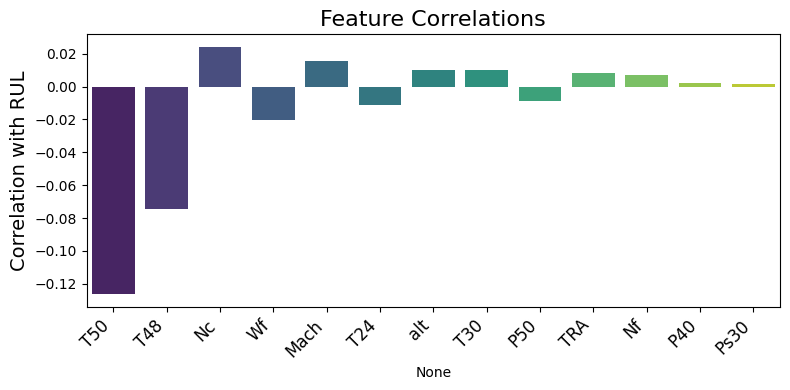

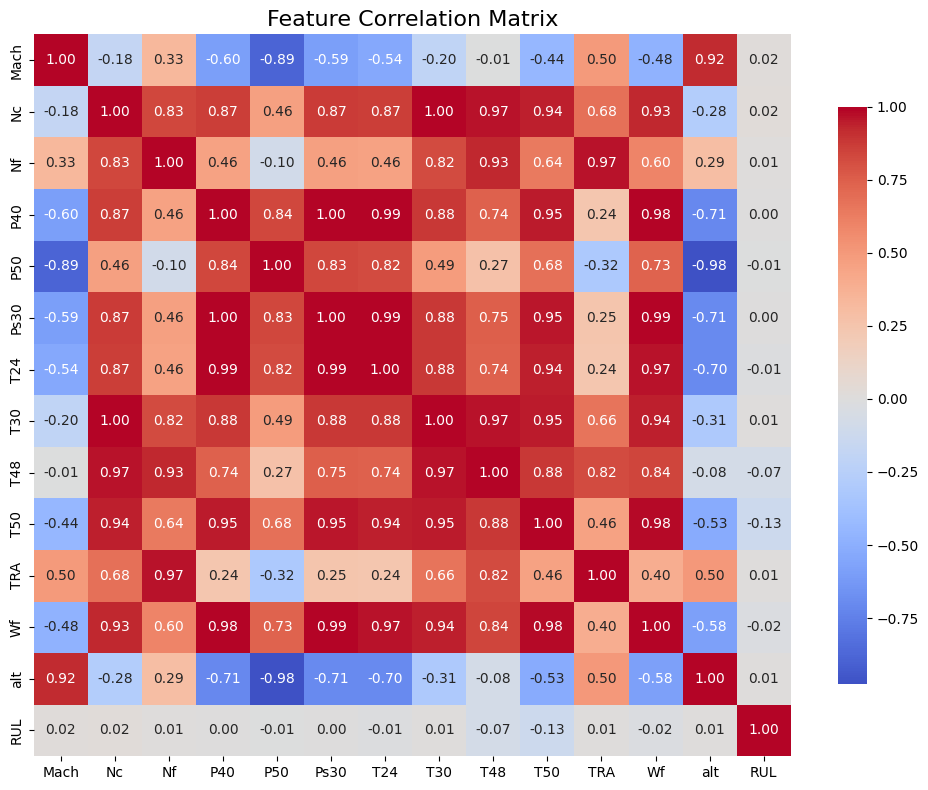

In [7]:
import seaborn as sns

fcols = feature_cols
corr = df_dev[fcols + ["RUL"]].corr()["RUL"].drop("RUL")
corr = corr.reindex(corr.abs().sort_values(ascending=False).index)

plt.figure(figsize=(8, 4))
sns.barplot(x=corr.index, y=corr.values, palette="viridis")
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylabel("Correlation with RUL", fontsize=14)
plt.title("Feature Correlations", fontsize=16)
plt.tight_layout()
plt.show()

fcols = feature_cols + ["RUL"]
corr = df_dev[fcols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .8}, center=0)
plt.title("Feature Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

#10% train
#10% test

engines = sorted(df_dev["engine_id"].unique())
train_ids, temp_ids = train_test_split(engines, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

train_df = df_dev[df_dev["engine_id"].isin(train_ids)].reset_index(drop=True)
val_df   = df_dev[df_dev["engine_id"].isin(val_ids)].reset_index(drop=True)
test_df  = df_dev[df_dev["engine_id"].isin(test_ids)].reset_index(drop=True)

print("Train engines:", train_df["engine_id"].nunique())
print("Validation engines:", val_df["engine_id"].nunique())
print("Test engines:", test_df["engine_id"].nunique())

Train engines: 4
Validation engines: 1
Test engines: 1


In [9]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
scaler.fit(train_df[feature_cols].values)

def transformdf(df):

    X = scaler.transform(df[feature_cols].values)
    df_new = df.copy()
    df_new[feature_cols] = X
    return df_new

train_df = transformdf(train_df)
val_df   = transformdf(val_df)
test_df  = transformdf(test_df)

X_train = train_df[feature_cols].values
y_train = train_df["RUL"].values
X_val   = val_df[feature_cols].values
y_val   = val_df["RUL"].values
X_test  = test_df[feature_cols].values
y_test  = test_df["RUL"].values


In [10]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import Adam
import math
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def sliding_window_make_sequence(df, feature_cols, target_col="RUL", window = 30, id_col = "engine_id"):
    
    x_sequences = []
    y_sequences = []
    for engineid, group in df.groupby(id_col):
        
        group = group.sort_values(["cycle"])
        features = group[feature_cols].values.astype(np.float32)
        targets = group[target_col].values.astype(np.float32)

        if len(group) <= window:
            continue

        for i in range(window, len(group)):
            x_sequences.append(features[i-window:i])
            y_sequences.append(targets[i])
        
    return np.stack(x_sequences), np.array(y_sequences)

window_size = 30
X_train_seq, y_train_seq = sliding_window_make_sequence(train_df, feature_cols, window=window_size)
X_val_seq, y_val_seq     = sliding_window_make_sequence(val_df, feature_cols, window=window_size)
X_test_seq, y_test_seq   = sliding_window_make_sequence(test_df, feature_cols, window=window_size)


In [12]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Looking in indexes: https://download.pytorch.org/whl/cu126
Note: you may need to restart the kernel to use updated packages.
CUDA available: True
GPU: NVIDIA RTX A500 Laptop GPU


In [ ]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class RULSequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32)).unsqueeze(1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = RULSequenceDataset(X_train_seq, y_train_seq)
val_dataset   = RULSequenceDataset(X_val_seq, y_val_seq)
test_dataset  = RULSequenceDataset(X_test_seq, y_test_seq)

batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

print(len(train_dataset), len(val_dataset), len(test_dataset))

torch.backends.cudnn.benchmark = True

Using device: cuda


In [14]:
import torch.nn as nn

class GRURULModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, bidirectional=False, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_dir = 2 if bidirectional else 1
        
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers,
                          batch_first=True, bidirectional=bidirectional, dropout=dropout if num_layers > 1 else 0.0)
        self.fc = nn.Linear(self.num_dir * hidden_dim, 1)

    def forward(self, x):
        out, temp = self.gru(x)
        last = temp[-1]
        yhat = self.fc(last)
        return yhat

input_dim = X_train_seq.shape[2]
model = GRURULModel(input_dim=input_dim, hidden_dim=32, num_layers=1, bidirectional=False)
model = model.to(device)
print(model)

GRURULModel(
  (gru): GRU(13, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [18]:
from torch.optim import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import copy

criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

def train_one_epoch(dataloader, model, optimizer):

    model.train()
    se_sum = 0.0
    nasa_sum = 0.0
    numsamples = 0

    for Xbatch, ybatch in dataloader:
        Xbatch = Xbatch.to(device, non_blocking=True)
        ybatch = ybatch.to(device, non_blocking=True)
             
        optimizer.zero_grad()

        ypred = model(Xbatch)
        loss = criterion(ypred, ybatch)
        
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            diff = (ybatch - ypred).view(-1) #this is for calculating the delta
            se_sum += (diff ** 2).sum().item()
            numsamples += diff.numel()

            alpha = torch.where(diff > 0, 
                                torch.full_like(diff, 1.0/13.0), 
                                torch.full_like(diff, 1.0/10.0)) #nasa score func
            
            nasa_sum += torch.exp(alpha * diff.abs()).sum().item()

    mse = se_sum/numsamples
    rmse = math.sqrt(mse)    
    return mse, rmse, nasa_sum

def evaluate_model(dataloader, model):

    model.eval()
    sesum = 0.0
    ae_sum = 0.0
    nasa_sum = 0.0
    numsamples = 0

    with torch.no_grad():
        for Xbatch, ybatch in dataloader:
            Xbatch = Xbatch.to(device, non_blocking=True)
            ybatch = ybatch.to(device, non_blocking=True)

            ypred = model(Xbatch)
            diff = (ybatch - ypred).view(-1)
    
            sesum += (diff ** 2).sum().item()
            ae_sum += diff.abs().sum().item()
            numsamples += diff.numel()

            alpha = torch.where(diff > 0,
                                torch.full_like(diff, 1.0/13.0),
                                torch.full_like(diff, 1.0/10.0))
            nasa_sum += torch.exp(alpha * diff.abs()).sum().item()

    mse = sesum/numsamples
    rmse = math.sqrt(sesum / numsamples)
    mae = ae_sum/numsamples
    return mse, rmse, mae, nasa_sum 

def evaluate_rmse_mae(loader, model):
    model.eval()
    se_sum = 0.0
    ae_sum = 0.0
    numsamples = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)
            y_pred = model(X_batch)
            
            se_sum += ((y_pred - y_batch) ** 2).sum().item()
            ae_sum += (y_pred-y_batch).abs().sum().item()
            numsamples += y_batch.numel()

    mse = se_sum / numsamples
    mae = ae_sum / numsamples
    rmse = math.sqrt(mse)
    return mse, rmse, mae

num_epochs = 80
val_every = 5  # not computing val every time for speed

best_val_rmse = float('inf')
best_model_state = None

for epoch in range(1, num_epochs + 1):
    train_mse, train_rmse, train_nasa = train_one_epoch(train_loader, model, optimizer)

    if epoch % val_every == 0 or epoch == 1:
        val_mse, val_rmse, val_mae, val_nasa = evaluate_model(val_loader, model)

        print(f"Epoch {epoch}/{num_epochs}")
        print(f"  TRAIN - MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, NASA s: {train_nasa:.4f}")
        print(f"  VAL   - MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, "
              f"MAE: {val_mae:.4f}, NASA s: {val_nasa:.4f}")

        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_model_state = copy.deepcopy(model.state_dict())
    else:
        print(f"Epoch {epoch}/{num_epochs}")
        print(f"  TRAIN - MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, NASA s: {train_nasa:.4f}")

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model with best VAL RMSE:", best_val_rmse)

# Final test evaluation
test_mse, test_rmse, test_mae, test_nasa = evaluate_model(test_loader, model)
print(f"TEST  - MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, "
      f"MAE: {test_mae:.4f}, NASA s: {test_nasa:.4f}")

Epoch 1/80
  TRAIN - MSE: 41.0368, RMSE: 6.4060, NASA s: 5821210.4946
  VAL   - MSE: 133.6317, RMSE: 11.5599, MAE: 7.2483, NASA s: 2357516.8118
Epoch 2/80
  TRAIN - MSE: 39.2826, RMSE: 6.2676, NASA s: 5756580.7446
Epoch 3/80
  TRAIN - MSE: 39.4600, RMSE: 6.2817, NASA s: 5733044.5558
Epoch 4/80
  TRAIN - MSE: 36.5012, RMSE: 6.0416, NASA s: 5615775.3618
Epoch 5/80
  TRAIN - MSE: 40.6555, RMSE: 6.3762, NASA s: 5786796.8966
  VAL   - MSE: 202.4734, RMSE: 14.2293, MAE: 8.9103, NASA s: 3313300.0082
Epoch 6/80
  TRAIN - MSE: 42.5272, RMSE: 6.5213, NASA s: 5890931.4651
Epoch 7/80
  TRAIN - MSE: 45.7684, RMSE: 6.7652, NASA s: 6111104.5795
Epoch 8/80
  TRAIN - MSE: 40.7266, RMSE: 6.3817, NASA s: 5823546.9033
Epoch 9/80
  TRAIN - MSE: 41.2853, RMSE: 6.4254, NASA s: 5883915.1399
Epoch 10/80
  TRAIN - MSE: 40.8314, RMSE: 6.3899, NASA s: 5853555.0251
  VAL   - MSE: 159.8131, RMSE: 12.6417, MAE: 7.6321, NASA s: 2822164.3438
Epoch 11/80
  TRAIN - MSE: 40.0978, RMSE: 6.3323, NASA s: 5781853.9214
Epoch 

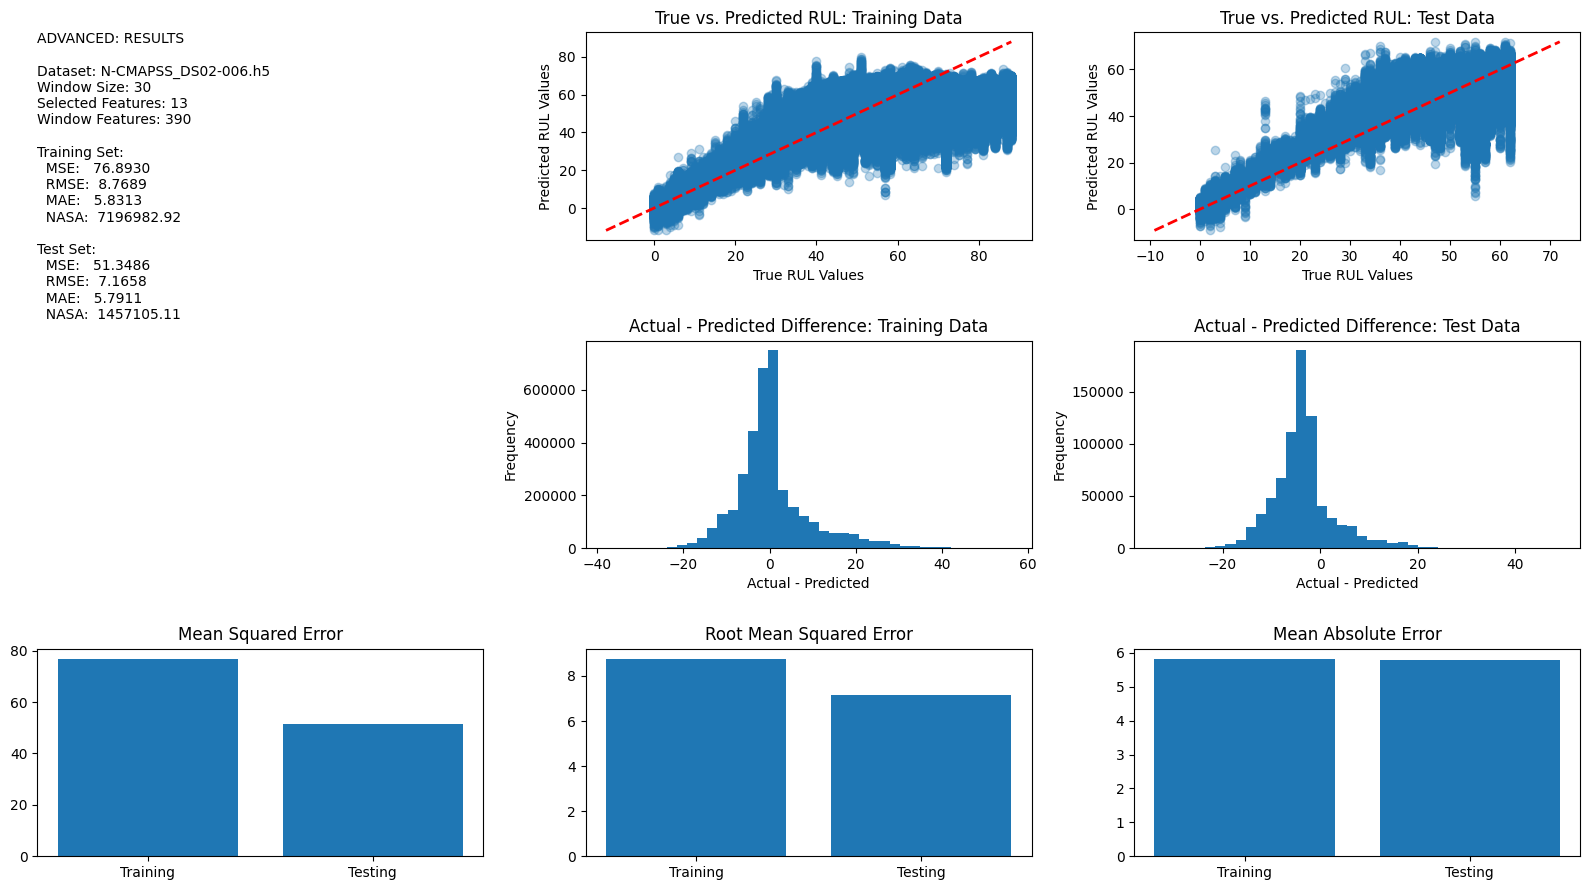

In [21]:
def get_preds(loader, model):

    model.eval()
    preds = []
    trues = []

    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            y_pred = model(X_batch)
            preds.append(y_pred.cpu().numpy())
            trues.append(Y_batch.cpu().numpy())
    
    preds = np.vstack(preds).ravel()
    trues = np.vstack(trues).ravel()
    return trues, preds

train_mse, train_rmse, train_mae, train_nasa = evaluate_model(train_loader, model)
test_mse, test_rmse, test_mae, test_nasa = evaluate_model(test_loader, model)

y_true_train, y_pred_train = get_preds(train_loader, model)
y_true_test, y_pred_test = get_preds(test_loader, model)


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

def plot_results_dashboard(
    y_true_train, y_pred_train,
    y_true_test,  y_pred_test,
    train_mse, train_rmse, train_mae, train_nasa,
    test_mse,  test_rmse,  test_mae,  test_nasa,
    dataset_name="N-CMAPSS_DS02-006.h5",
    window_size=30,
    n_selected_features=None,
    n_window_features=None
):
    fig = plt.figure(figsize=(16, 9))
    gs = gridspec.GridSpec(3, 3, figure=fig)
    
    ax_text = fig.add_subplot(gs[0, 0])
    ax_text.axis("off")
    
    lines = [
        "ADVANCED: RESULTS",
        "",
        f"Dataset: {dataset_name}",
        f"Window Size: {window_size}",
    ]
    if n_selected_features is not None:
        lines.append(f"Selected Features: {n_selected_features}")
    if n_window_features is not None:
        lines.append(f"Window Features: {n_window_features}")
    lines.append("")
    lines.append("Training Set:")
    lines.append(f"  MSE:   {train_mse:.4f}")
    lines.append(f"  RMSE:  {train_rmse:.4f}")
    lines.append(f"  MAE:   {train_mae:.4f}")
    lines.append(f"  NASA:  {train_nasa:.2f}")
    lines.append("")
    lines.append("Test Set:")
    lines.append(f"  MSE:   {test_mse:.4f}")
    lines.append(f"  RMSE:  {test_rmse:.4f}")
    lines.append(f"  MAE:   {test_mae:.4f}")
    lines.append(f"  NASA:  {test_nasa:.2f}")
    
    ax_text.text(
        0.0, 1.0,
        "\n".join(lines),
        va="top", ha="left",
        fontsize=10,
    )
    
    ax1 = fig.add_subplot(gs[0, 1])
    ax1.scatter(y_true_train, y_pred_train, alpha=0.3)
    min_val = min(y_true_train.min(), y_pred_train.min())
    max_val = max(y_true_train.max(), y_pred_train.max())
    ax1.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=2)
    ax1.set_xlabel("True RUL Values")
    ax1.set_ylabel("Predicted RUL Values")
    ax1.set_title("True vs. Predicted RUL: Training Data")
    
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.scatter(y_true_test, y_pred_test, alpha=0.3)
    min_val = min(y_true_test.min(), y_pred_test.min())
    max_val = max(y_true_test.max(), y_pred_test.max())
    ax2.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=2)
    ax2.set_xlabel("True RUL Values")
    ax2.set_ylabel("Predicted RUL Values")
    ax2.set_title("True vs. Predicted RUL: Test Data")
    
    train_resid = y_true_train - y_pred_train
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.hist(train_resid, bins=40)
    ax3.set_title("Actual - Predicted Difference: Training Data")
    ax3.set_xlabel("Actual - Predicted")
    ax3.set_ylabel("Frequency")
    
    test_resid = y_true_test - y_pred_test
    ax4 = fig.add_subplot(gs[1, 2])
    ax4.hist(test_resid, bins=40)
    ax4.set_title("Actual - Predicted Difference: Test Data")
    ax4.set_xlabel("Actual - Predicted")
    ax4.set_ylabel("Frequency")

    ax5 = fig.add_subplot(gs[2, 0])
    ax5.bar(["Training", "Testing"], [train_mse, test_mse])
    ax5.set_title("Mean Squared Error")

    ax6 = fig.add_subplot(gs[2, 1])
    ax6.bar(["Training", "Testing"], [train_rmse, test_rmse])
    ax6.set_title("Root Mean Squared Error")

    ax7 = fig.add_subplot(gs[2, 2])
    ax7.bar(["Training", "Testing"], [train_mae, test_mae])
    ax7.set_title("Mean Absolute Error")
    
    fig.tight_layout()
    plt.show()


plot_results_dashboard(
    y_true_train, y_pred_train,
    y_true_test,  y_pred_test,
    train_mse, train_rmse, train_mae, train_nasa,
    test_mse,  test_rmse,  test_mae,  test_nasa,
    dataset_name="N-CMAPSS_DS02-006.h5",
    window_size=window_size,
    n_selected_features=len(feature_cols),
    n_window_features=X_train_seq.shape[1] * X_train_seq.shape[2] 
)



